# prologue

### set up notebook and load package

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import numpy as np
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

# demo datasets that ship with package. all from UCI unless stated otherwise
# import CHIRPS.datasets as ds
# ds.adult_data, ds.adult_samp_data, ds.adult_small_samp_data Large dataset ships with manageable sub samples
# ds.bankmark_data, ds.bankmark_samp_data
# ds.car_data
# ds.cardio_data this is the cardiotocography dataset
# ds.credit_data
# ds.german_data
# ds.lending_data, ds.lending_samp_data, ds.lending_small_samp_data, ds.lending_tiny_samp_data from Kaggle. see datasets_from_source file for links
# ds.nursery_data, ds.nursery_samp_data
# ds.rcdv_data, ds.rcdv_samp_data from US government see datasets_from_source file for links

### common config - can be ommitted if defaults are OK

In [2]:
# location to save results
project_dir = '/datadisk/whiteboxing/examples'
# project_dir = 'V:\\whiteboxing\\2020' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\2020'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Build a Random Forest Model to Predict and Explain
First, a wrapper is created for the dataset. Use one that ships with the package, or create your own.
Then split the data into training and (hold out) test set using the convenience functions in the package. These return an object that contain the split data in various representations, such as Pandas DataFrames and encoded, sparse matrices.

/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.7586
Best parameters:{'max_depth': 32.0, 'n_estimators': 1600, 'oob_score': True, 'random_state': 123}

Confusion matrix, without normalization
[[193  19]
 [ 46  42]]


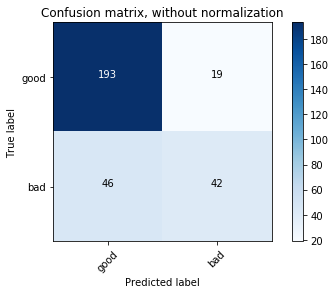

Normalized confusion matrix
[[0.91 0.09]
 [0.52 0.48]]


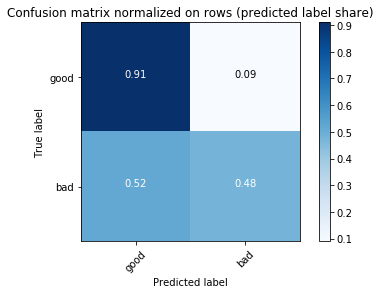

In [3]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.german(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# CHOOSE ONE
model = 'RandomForest'
# model = 'AdaBoost1' # SAMME
# model = 'AdaBoost2' # SAMME.R
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        # real-valued AdaBoost
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM
    tuning.update({'grid' : {'subsample' : [0.5],
                        'n_estimators': [i * 200 for i in range(1, 9)],
                        'max_depth' : [i for i in range(1, 5)],
                        'learning_rate': np.full(4, 10.0)**[i for i in range(-3, 1)]}})

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.7486
Best parameters:{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 400, 'random_state': 123}

Confusion matrix, without normalization
[[166  46]
 [ 40  48]]


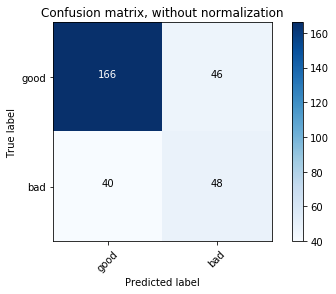

Normalized confusion matrix
[[0.78 0.22]
 [0.45 0.55]]


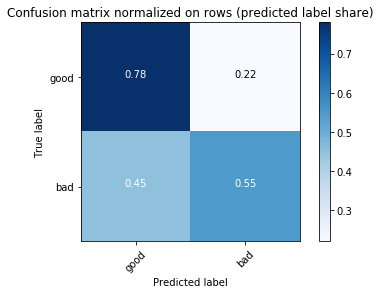

In [4]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.german(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# CHOOSE ONE
# model = 'RandomForest'
model = 'AdaBoost1' # SAMME
# model = 'AdaBoost2' # SAMME.R
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        # real-valued AdaBoost
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM
    tuning.update({'grid' : {'subsample' : [0.5],
                        'n_estimators': [i * 200 for i in range(1, 9)],
                        'max_depth' : [i for i in range(1, 5)],
                        'learning_rate': np.full(4, 10.0)**[i for i in range(-3, 1)]}})

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

using previous tuning parameters


/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Best OOB Accuracy Estimate during tuning: 0.7329
Best parameters:{'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 600, 'random_state': 123}

Confusion matrix, without normalization
[[179  33]
 [ 40  48]]


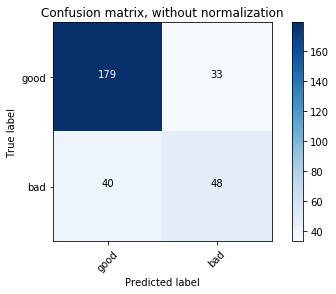

Normalized confusion matrix
[[0.84 0.16]
 [0.45 0.55]]


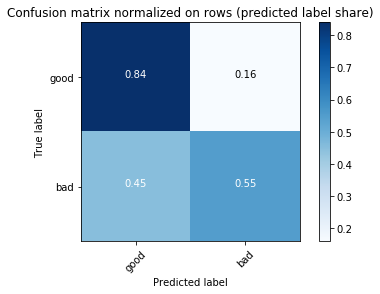

In [5]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.german(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# CHOOSE ONE
# model = 'RandomForest'
# model = 'AdaBoost1' # SAMME
model = 'AdaBoost2' # SAMME.R
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        # real-valued AdaBoost
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM
    tuning.update({'grid' : {'subsample' : [0.5],
                        'n_estimators': [i * 200 for i in range(1, 9)],
                        'max_depth' : [i for i in range(1, 5)],
                        'learning_rate': np.full(4, 10.0)**[i for i in range(-3, 1)]}})

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.7643
Best parameters:{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1600, 'subsample': 0.5, 'random_state': 123}

Confusion matrix, without normalization
[[176  36]
 [ 35  53]]


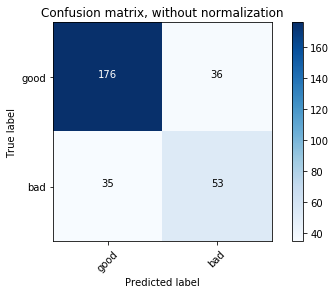

Normalized confusion matrix
[[0.83 0.17]
 [0.4  0.6 ]]


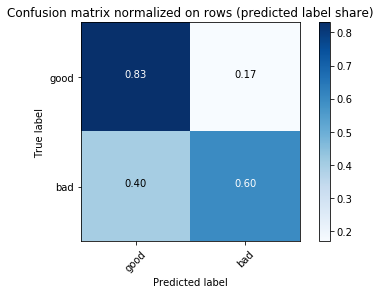

In [6]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.german(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# CHOOSE ONE
# model = 'RandomForest'
# model = 'AdaBoost1' # SAMME
# model = 'AdaBoost2' # SAMME.R
model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        # real-valued AdaBoost
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM
    tuning.update({'grid' : {'subsample' : [0.5],
                        'n_estimators': [i * 200 for i in range(1, 9)],
                        'max_depth' : [i for i in range(1, 5)],
                        'learning_rate': np.full(4, 10.0)**[i for i in range(-3, 1)]}})

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

In [10]:
mydata.data.loc[131]

chk         A11
dur          36
crhis       A33
pps         A46
amt        6887
svng        A61
emp         A73
rate          4
pers        A93
debt       A101
res           3
prop       A122
age          29
plans      A142
hous       A152
creds         1
job        A173
deps          1
tel        A192
foreign    A201
rating      bad
Name: 131, dtype: object